# Ecommerce A/B testing

## Business Understanding

For this project, we are working to understand the results of an A/B test run by an e-commerce website. The company has developed a new web page in order to try and increase the number of users who "convert," meaning the number of users who decide to pay for the company's product. Your goal is to work through this notebook to help the company understand if they should implement this new page, keep the old page, or perhaps run the experiment longer to make their decision.

## Data Understanding

The data is from [kaggle](https://www.kaggle.com/datasets/putdejudomthai/ecommerce-ab-testing-2022-dataset1?resource=download)

There are 5 columns
 - user_id
 - timestamp
 - group
 - landing_page
 - converted

### Loading the data

In [1]:
# importing modules
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
import scipy.stats as stats

%matplotlib inline

In [2]:
# reading the data
df = pd.read_csv('/kaggle/input/ecommerce-ab-testing-2022-dataset1/ecommerce_ab_testing_2022_dataset1/ab_data.csv')

df

,user_id,timestamp,group,landing_page,converted
0,851104,11:48.6,control,old_page,0
1,804228,01:45.2,control,old_page,0
2,661590,55:06.2,treatment,new_page,0
3,853541,28:03.1,treatment,new_page,0
4,864975,52:26.2,control,old_page,1
...,...,...,...,...,...
294475,734608,45:03.4,control,old_page,0
294476,697314,20:29.0,control,old_page,0
294477,715931,40:24.5,treatment,new_page,0
294478,759899,20:29.0,treatment,new_page,0


Data is correctly loaded, has 5 columns
Now we check more info

## 1. Exploratory Data Analysis

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294480 entries, 0 to 294479
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294480 non-null  int64 
 1   timestamp     294480 non-null  object
 2   group         294480 non-null  object
 3   landing_page  294480 non-null  object
 4   converted     294480 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


No missing values in all columns. We also notice that there are two data types and a total of about 294k entries

In [4]:
df.duplicated().sum()

0

No duplicated rows in the data

### (a). Inspecting the Columns

In [5]:
# check all the columns
df.columns

Index(['user_id', 'timestamp', 'group', 'landing_page', 'converted'], dtype='object')

Total of 5 columns. let's start with the group column

#### The group column

In [6]:
df.group.value_counts(normalize=True)

group
treatment    0.500129
control      0.499871
Name: proportion, dtype: float64

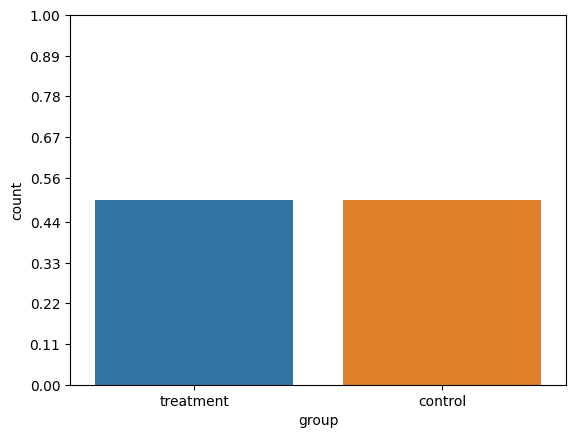

In [7]:
# plotting the distribution
value_df = df.group.value_counts(normalize=True).reset_index()

value_df.columns = ['group', 'count']
ax = sns.barplot(data=value_df, x='group', y='count')

# setting y scale
ax.set_yticks(np.linspace(0,1, 10).round(2));

The group column is categorical with two categories, treatment and control.

Both categories contain almost 50% of the data each.

#### The landing_page column

In [8]:
# The landing_page column
df.landing_page.value_counts(normalize=True)

landing_page
new_page    0.500003
old_page    0.499997
Name: proportion, dtype: float64

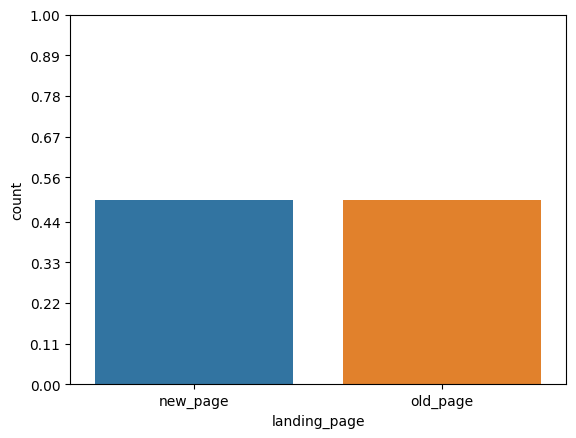

In [9]:
# plotting the distribution
value_df = df.landing_page.value_counts(normalize=True).reset_index()

value_df.columns = ['landing_page', 'count']
ax = sns.barplot(data=value_df, x='landing_page', y='count')

# setting y scale
ax.set_yticks(np.linspace(0,1, 10).round(2));

Same case for landing_page, there are two categories - new_page and old_page

The data is distributed almost the same across the groups(around 50%)

#### The 'converted' column

In [10]:
# 'converted' column
df.converted.value_counts(normalize=True)

converted
0    0.880342
1    0.119658
Name: proportion, dtype: float64

In the converted column, there are two values- 0 and 1

- 0 - about 88% did not convert
- 1 - about 12% converted

#### The 'timestamp' column

In [11]:
df.timestamp.dtype

dtype('O')

Timestamp column is in string format. We convert it to the appropriate format

In [12]:
df.timestamp = pd.to_timedelta("00:" + df.timestamp)

df.timestamp.head()

0   0 days 00:11:48.600000
1   0 days 00:01:45.200000
2   0 days 00:55:06.200000
3   0 days 00:28:03.100000
4   0 days 00:52:26.200000
Name: timestamp, dtype: timedelta64[ns]

checking how long the test took

In [13]:
df.timestamp.max() - df.timestamp.min()

Timedelta('0 days 00:59:59.900000')

the test was conducted for one hour

### (b). The control and treatment group

We first group by the group and what landing page each is exposed to 

In [14]:
df.groupby(['group', 'landing_page']).size().reset_index(name='count')

,group,landing_page,count
0,control,new_page,1928
1,control,old_page,145274
2,treatment,new_page,145313
3,treatment,old_page,1965


We notice that for the control group, some few members are exposed to new page  and majority to the old page.

Same case in  the treatment group some are exposed to the old page and the majority to the new page

#### Fix this to ensure that control group contains people exposed to the old page and the opposite for the treatment group

In [15]:
# filtering the df
df = df.loc[
    ((df.group == 'control') & (df.landing_page == 'old_page')) |
    ((df.group == 'treatment') & (df.landing_page == 'new_page'))
]

# check new df
df.groupby(['group', 'landing_page']).size().reset_index(name='count')

,group,landing_page,count
0,control,old_page,145274
1,treatment,new_page,145313


Now we group the data to obtain only the control group and the treatment group separately to investigate further

In [16]:
# split the data according to the group
control_group = df.loc[df.group == 'control']
treatment_group = df.loc[df.group == 'treatment']

## 2. A/B Testing

Our metric is the number of people who converted

### Hypothesis definition

H0: conversion rate for control group $\leq$ conversion rate for treatment group

H1: conversion rate for control group $\gt$ conversion rate for treatment group

In [17]:
# get the total converted
converted_df = df.groupby(['group', 'converted']).size().unstack()

converted_df.columns = ['not_converted', 'converted']

# Rearrange the columns
converted_df = converted_df.loc[:, ['converted', 'not_converted']]

converted_df

,converted,not_converted
group,,
control,17489,127785
treatment,17264,128049


Now we have the number of people who converted and those who did not convert in both groups

We can use the Fishers exact test to test for any difference in the two groups

### Fishers exact test

In [18]:
p_value = stats.fisher_exact(converted_df, alternative='greater')[1]

print('P value:', p_value)

P value: 0.09556240742843122


The p value is greater than $\alpha$ ie 0.05

We fail to reject the null hypothesis at $\alpha$ = 0.05 and conclude that the conversion rate for the new webpage is not greater than that of the old page